# <span style="color: green; font-size: 40px; font-weight: bold;">Lab 1 (Regressão Linear com PySpark) </span>

<br> <br>

# Prevendo o Consumo de Combustível de Automóveis com PySpark e Machine Learning

<br>

### Contexto

Neste projeto, vamos explorar um importante contexto de negócio na área automotiva: a **previsão do consumo de combustível de automóveis**. O projeto será desenvolvido desde a concepção do problema de negócio até a entrega de um modelo preditivo, utilizando ferramentas comuns de análise de dados no dia a dia de um Cientista de Dados.

<br>

### Objetivo

O objetivo deste projeto é **construir um modelo de Machine Learning capaz de prever o consumo de combustível de automóveis**. Usaremos dados históricos de consumo de combustível para treinar o modelo. Este modelo será capaz de prever o consumo de combustível a partir de novas entradas de dados, como número de cilindros, capacidade, horsepower, peso, aceleração, ano e nome do automóvel.

<br>

### Pergunta de Negócio Principal

> "Como podemos prever o consumo de combustível de automóveis usando dados históricos?"

<br>

### Entregável

O entregável deste projeto será um **modelo de Machine Learning treinado para prever o consumo de combustível de automóveis**. O modelo será desenvolvido utilizando dados históricos de consumo de combustível e será capaz de fazer previsões com base em novos dados de entrada. O processo incluirá a concepção do problema de negócio, preparação dos dados, desenvolvimento do modelo, e a entrega do modelo preditivo.

<br>

### Sobre o Conjunto de Dados

Os dados utilizados neste projeto abrangem diversas características dos automóveis, incluindo número de cilindros, capacidade, horsepower, peso, aceleração, ano e nome do automóvel. A variável de consumo será a variável alvo (dependente) e as demais variáveis serão candidatas a features (variáveis preditoras ou independentes).

Para este projeto, utilizaremos o conjunto de dados "dataset1.csv", que contém informações detalhadas sobre automóveis e seus respectivos consumos de combustível.

<br>

<table border="2">
  <tr>
    <th style="text-align: center; font-size: 16px;">Nome da Coluna</th>
    <th style="text-align: center; font-size: 16px;">Tipo de Dado</th>
    <th style="text-align: center; font-size: 16px;">Descrição</th>
  </tr>
  <tr>
    <td>consumo <b>(variável alvo)</b></td>
    <td>integer</td>
    <td>Consumo de combustível do automóvel em milhas por galão (mpg).</td>
  </tr>
  <tr>
    <td>numero_cilindros</td>
    <td>integer</td>
    <td>Número de cilindros do motor do automóvel.</td>
  </tr>
  <tr>
    <td>capacidade</td>
    <td>integer</td>
    <td>Capacidade do motor do automóvel em polegadas cúbicas.</td>
  </tr>
  <tr>
    <td>horsepower</td>
    <td>integer</td>
    <td>Potência do motor do automóvel em cavalos de força.</td>
  </tr>
  <tr>
    <td>peso</td>
    <td>integer</td>
    <td>Peso do automóvel em libras.</td>
  </tr>
  <tr>
    <td>aceleracao</td>
    <td>float</td>
    <td>Tempo necessário para o automóvel ir de 0 a 60 mph em segundos.</td>
  </tr>
  <tr>
    <td>ano</td>
    <td>integer</td>
    <td>Ano de fabricação do automóvel.</td>
  </tr>
  <tr>
    <td>nome</td>
    <td>string</td>
    <td>Nome do automóvel.</td>
  </tr>
</table>

<br><br><br>

# Importando Pacotes

In [54]:
# Importa o findspark e inicializa
import findspark
findspark.init()

# Imports
import numpy as np
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

## Bibliotecas de Visualização de Dados

import seaborn as sns                    # Biblioteca para visualização de dados estatísticos.
from matplotlib import pyplot as plt     # Biblioteca para criação de gráficos e visualizações.

# Importações necessárias
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline, PipelineModel

<br> <br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Preparando o Ambiente Spark</span>

In [2]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

# Se houver uma sessão Spark ativa, encerre-a
if 'sc' in globals():
    sc.stop()

if 'spark' in globals():
    spark.stop()


# Criando o Spark Context
conf = SparkConf().setAppName("Lab1") \
                  .set("spark.ui.showConsoleProgress", "false") \
                  .set("spark.executor.heartbeatInterval", "20s") \
                  .set("spark.eventLog.enabled", "false") \
                  .set("spark.sql.shuffle.partitions", "2") \
                  .set("spark.sql.debug.maxToStringFields", "100") \
                  .set("spark.executor.memory", "4g") \
                  .set("spark.driver.memory", "4g") \
                  .set("spark.driver.maxResultSize", "2g")  # Configuração adicional para limitar o tamanho do resultado

# Criar o Spark Context e a Spark Session
sc = SparkContext(conf=conf)
spSession = SparkSession.builder.config(conf=conf).getOrCreate()

# Ajustar o nível de log para ERROR
sc.setLogLevel("ERROR")

# Configurar log4j para suprimir avisos (deixar como comentário e volta ao normal)
log4j_logger = sc._jvm.org.apache.log4j
log4j_logger.LogManager.getLogger("org").setLevel(log4j_logger.Level.ERROR)
log4j_logger.LogManager.getLogger("akka").setLevel(log4j_logger.Level.ERROR)

# Visualizar o objeto spark_session
spSession

24/08/07 17:38:01 WARN Utils: Your hostname, eduardo-Inspiron-15-3520 resolves to a loopback address: 127.0.1.1; using 192.168.0.13 instead (on interface wlp0s20f3)
24/08/07 17:38:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/07 17:38:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Carregando os Dados</span>

- Os dados serão carregados a partir de um arquivo CSV e gerados como um RDD (Resilient Distributed Dataset) no Apache Spark. O RDD é uma estrutura de dados distribuída que permite o processamento paralelo em um cluster, otimizando a performance.

In [3]:
# Carregando os dados e gerando um RDD
dados = sc.textFile("Lab/dados/dataset1.csv")

# Tipo
print(type(dados), '\n')

# Colocando o RDD em cache. Esse processo otimiza a performance
print(dados.cache(), '\n')

# Número de registros
print(dados.count(), '\n')

<class 'pyspark.rdd.RDD'> 

Lab/dados/dataset1.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 

399 



In [4]:
# Visualizando as primeiras linhas
print(dados.take(5))

['consumo,numero_cilindros,capacidade,horsepower,peso,aceleracao,ano,nome', '30,4,79,70,2074,19.5,71,peugeot 304', '30,4,88,76,2065,14.5,71,fiat 124b', '31,4,71,65,1773,19,71,toyota corolla 1200', '35,4,72,69,1613,18,71,datsun 1200']


In [1]:
# Visualizando primeiras 5 linhas com Pandas (Apenas para visualização)

import pandas as pd

# Obter as primeiras 5 linhas do RDD
linhas = dados.take(5)

# Dividir as linhas em colunas
colunas = linhas[0].split(",")
dados_formatados = [linha.split(",") for linha in linhas[1:]]

# Criar um DataFrame Pandas
df = pd.DataFrame(dados_formatados, columns=colunas)

# Mostrar o DataFrame
display(df)

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

NameError: name 'dados' is not defined

<br>

### Criando novo objeto RDD sem a primeira linha do arquivo (cabeçalho)

In [6]:
# Removendo a primeira linha do arquivo (cabeçalho)
dados2 = dados.filter(lambda x: "horsepower" not in x)
dados2.count()

398

<br><br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;"> Análise Exploratória Inicial dos Dados </span>

<br>

### Criação de Função Para Análise Inicial

In [7]:
import pandas as pd
import re

def funcao_analise_inicial(df):
    # Configurar Pandas para exibir todas as linhas
    pd.set_option('display.max_rows', None)

    # Informações do DataFrame
    print('\n\n INFO \n\n')
    df.info()
    print('\n\n ------------------------------------------------------------------------------------------ \n\n')

    # Verifica se há valores ausentes e duplicados
    valores_ausentes = df.isna().sum().sum() > 0
    valores_duplicados = df.duplicated().sum() > 0

    # Nomes das variáveis com valores ausentes
    variaveis_ausentes = df.columns[df.isna().any()].tolist()

    # Número de linhas duplicadas
    num_linhas_duplicadas = df.duplicated().sum()

    # Porcentagem de linhas duplicadas
    porcentagem_linhas_duplicadas = (num_linhas_duplicadas / len(df)) * 100

    # Exibe o resultado sobre valores ausentes e duplicados
    print("\n\nExistem valores ausentes:", valores_ausentes)
    if valores_ausentes:
        print("\nVariáveis com valores ausentes:", variaveis_ausentes)
    else:
        print("\nNenhuma variável possui valores ausentes.")

    print("\n\nExistem valores duplicados:", valores_duplicados)
    if valores_duplicados:
        print("\nNúmero de Linhas Duplicadas:", num_linhas_duplicadas)
        print("\nPorcentagem de Linhas Duplicadas: {:.2f}%".format(porcentagem_linhas_duplicadas))
    else:
        print("\nNenhuma variável possui valores duplicados.")
    
    # Verificação de caracteres especiais
    caracteres_especiais = re.compile('[@_!#$%^&*<>?/\\|}{~:]')   # removido caracter de parenteses
    colunas_com_caracteres_especiais = {}

    for coluna in df.columns:
        if df[coluna].dtype == 'object':  # Verifica apenas colunas de texto
            contem_caracteres_especiais = df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False)).any()
            if contem_caracteres_especiais:
                indices_com_caracteres_especiais = df[coluna][df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False))].index.tolist()
                colunas_com_caracteres_especiais[coluna] = indices_com_caracteres_especiais

    # Exibe o resultado sobre caracteres especiais
    print("\n\nExistem caracteres especiais nas colunas:", bool(colunas_com_caracteres_especiais))
    if colunas_com_caracteres_especiais:
        print("\nColunas com caracteres especiais e os índices:")
        for coluna, indices in colunas_com_caracteres_especiais.items():
            print(f"\n Coluna [ {coluna} ]: Índices com caracteres especiais {indices}")
    else:
        print("\nNenhuma coluna possui caracteres especiais.")

<br>

### Transformando dados carregados em RDD para dataframe do Pandas (apenas para Análise Inicial)

- Vamos realizar análise exploratória através da função acima. RDDs são ótimos para processamento, mas ruins para exploração, então converteremos o RDD para DataFrame Spark e então para DataFrame Pandas (**não é possível converter diretamente objeto RDD para objeto Pandas**).

In [8]:
# Converte RDD para DataFrame Spark
header = dados.first().split(',')
df_spark_com_cabecalho = dados.map(lambda x: x.split(',')).toDF(header)
print(type(df_spark_com_cabecalho), '\n')

# Converte DataFrame Spark para DataFrame Pandas
df_pandas = df_spark_com_cabecalho.toPandas()
df_pandas = df_pandas.iloc[1:, :].reset_index(drop=True)
print(type(df_pandas), '\n')

# Visualizando
display(df_pandas.head())

<class 'pyspark.sql.dataframe.DataFrame'> 

<class 'pandas.core.frame.DataFrame'> 



,consumo,numero_cilindros,capacidade,horsepower,peso,aceleracao,ano,nome
0,30,4,79,70,2074,19.5,71,peugeot 304
1,30,4,88,76,2065,14.5,71,fiat 124b
2,31,4,71,65,1773,19,71,toyota corolla 1200
3,35,4,72,69,1613,18,71,datsun 1200
4,27,4,97,60,1834,19,71,volkswagen model 111


<br>

### Visualizando Função para Análise Inicial

In [9]:
# Chamando Função para Análise Inicial
funcao_analise_inicial(df_pandas)



 INFO 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   consumo           398 non-null    object
 1   numero_cilindros  398 non-null    object
 2   capacidade        398 non-null    object
 3   horsepower        398 non-null    object
 4   peso              398 non-null    object
 5   aceleracao        398 non-null    object
 6   ano               398 non-null    object
 7   nome              398 non-null    object
dtypes: object(8)
memory usage: 25.0+ KB


 ------------------------------------------------------------------------------------------ 




Existem valores ausentes: False

Nenhuma variável possui valores ausentes.


Existem valores duplicados: False

Nenhuma variável possui valores duplicados.


Existem caracteres especiais nas colunas: True

Colunas com caracteres especiais e os índices:

 Coluna [ horsepower ]: Índices

### Resumo

- Será necessário um tratamento para coluna **horsepower**.

<br> <br> <br> <br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Limpeza nos Dados</span>

- Nesta etapa trataremos os valores com caracteres e especiais e realização a conversão do tipo das colunas para tipo float
- Usaremos o objeto *dados2* (objeto RDD sem a primeira linha do arquivo (cabeçalho))

<br> <br>

## Tratando Valores com Caracteres Especiais

- Iremos substituir todos valores com caracter especial da coluna *horsepower* pelo **valor numérico 75**.

<br>

Será definido uma variável de broadcast com um valor arbitrário no Spark para otimizar o desempenho ao distribuir o valor para todos os nós do cluster.

In [10]:
## Criando variável de broadcast mediaHP

# Usando um valor padrão para average HP (que será usado para preencher os valores ausentes)
mediaHP = sc.broadcast(75.0)

In [11]:
# Função para tratamento de valores e conversão do tipo das colunas de string para float
def limpaDados(inputStr) :
    
    # Variável global
    global mediaHP
    
    # Lista de atributos
    attList = inputStr.split(",")
    
    # Substitui o caracter ? por um valor na coluna de índice 3
    hpValue = attList[3]
    if hpValue == "?":
        hpValue = mediaHP.value
       
    # Cria uma linha usando a função Row, limpando e convertendo os dados de string para float
    linhas = Row(consumo = float(attList[0]), 
                 numero_cilindros = float(attList[1]), 
                 capacidade = float(attList[2]), 
                 hosrsepower = float(hpValue), 
                 peso = float(attList[4]), 
                 aceleracao = float(attList[5]), 
                 ano = float(attList[6]), 
                 nome = attList[7]) 
    return linhas

# Executa a função no RDD
dados3 = dados2.map(limpaDados)

# Colocando o RDD em cache. Esse processo otimiza a performance
dados3.cache()

PythonRDD[14] at RDD at PythonRDD.scala:53

In [12]:
# Visualizando as primeiras linhas do RDD após a limpeza
print(dados3.take(5))

[Row(consumo=30.0, numero_cilindros=4.0, capacidade=79.0, hosrsepower=70.0, peso=2074.0, aceleracao=19.5, ano=71.0, nome='peugeot 304'), Row(consumo=30.0, numero_cilindros=4.0, capacidade=88.0, hosrsepower=76.0, peso=2065.0, aceleracao=14.5, ano=71.0, nome='fiat 124b'), Row(consumo=31.0, numero_cilindros=4.0, capacidade=71.0, hosrsepower=65.0, peso=1773.0, aceleracao=19.0, ano=71.0, nome='toyota corolla 1200'), Row(consumo=35.0, numero_cilindros=4.0, capacidade=72.0, hosrsepower=69.0, peso=1613.0, aceleracao=18.0, ano=71.0, nome='datsun 1200'), Row(consumo=27.0, numero_cilindros=4.0, capacidade=97.0, hosrsepower=60.0, peso=1834.0, aceleracao=19.0, ano=71.0, nome='volkswagen model 111')]


<br><br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;"> Análise Exploratória</span>

<br>

- Realizando uma nova etapa de <i>Análise Exploratória</i> agora com os dados já <i>tratados</i>.

<br>

#### Convertendo para Dataframe do Spark

In [13]:
# Cria um Dataframe
df_carros = spSession.createDataFrame(dados3)
print(type(df_carros), '\n')

print(df_carros.show(2))

<class 'pyspark.sql.dataframe.DataFrame'> 

+-------+----------------+----------+-----------+------+----------+----+-----------+
|consumo|numero_cilindros|capacidade|hosrsepower|  peso|aceleracao| ano|       nome|
+-------+----------------+----------+-----------+------+----------+----+-----------+
|   30.0|             4.0|      79.0|       70.0|2074.0|      19.5|71.0|peugeot 304|
|   30.0|             4.0|      88.0|       76.0|2065.0|      14.5|71.0|  fiat 124b|
+-------+----------------+----------+-----------+------+----------+----+-----------+
only showing top 2 rows

None


In [14]:
# Visualizar o resumo estatístico do DataFrame
#df_carros.describe().show()

# Visualizar o resumo estatístico do DataFrame
summary = df_carros.describe()

# Converte o resumo estatístico para DataFrame Pandas
summary_pandas = summary.toPandas()

# Configurar Pandas para exibir todas as colunas
pd.set_option('display.max_columns', None)

# Visualizar o resumo estatístico no formato Pandas
display(summary_pandas)

,summary,consumo,numero_cilindros,capacidade,hosrsepower,peso,aceleracao,ano,nome
0,count,398,398,398,398,398,398,398,398
1,mean,23.51457286432161,5.454773869346734,193.42587939698493,104.0251256281407,2970.424623115578,15.568090452261309,76.01005025125629,None
2,stddev,7.815984312565782,1.701004244533212,104.26983817119587,38.36802263035616,846.8417741973268,2.7576889298126757,3.697626646732597,None
3,min,9.0,3.0,68.0,46.0,1613.0,8.0,70.0,amc ambassador brougham
4,max,46.6,8.0,455.0,230.0,5140.0,24.8,82.0,vw rabbit custom


<br><br><br>

# Verificando Correlação

<br>

- Vamos verificar a correlação usando o objeto dataframe pyspark.
- **Apenas variáveis numéricas** são selecionadas automaticamente.

In [15]:
## Verificando Correlação através do dataframe pyspark

# Encontrando a correlação entre a variável target com as variáveis preditoras (exceto a coluna 'nome')
for i in df_carros.columns:
    if not(isinstance(df_carros.select(i).take(1)[0][0], str)) :
        print("Correlação da Variável Target com:", i, df_carros.stat.corr('consumo', i))
print('\n')

Correlação da Variável Target com: consumo 1.0
Correlação da Variável Target com: numero_cilindros -0.7753962854205548
Correlação da Variável Target com: capacidade -0.8042028248058978
Correlação da Variável Target com: hosrsepower -0.774704152349872
Correlação da Variável Target com: peso -0.8317409332443347
Correlação da Variável Target com: aceleracao 0.4202889121016496
Correlação da Variável Target com: ano 0.5792671330833099




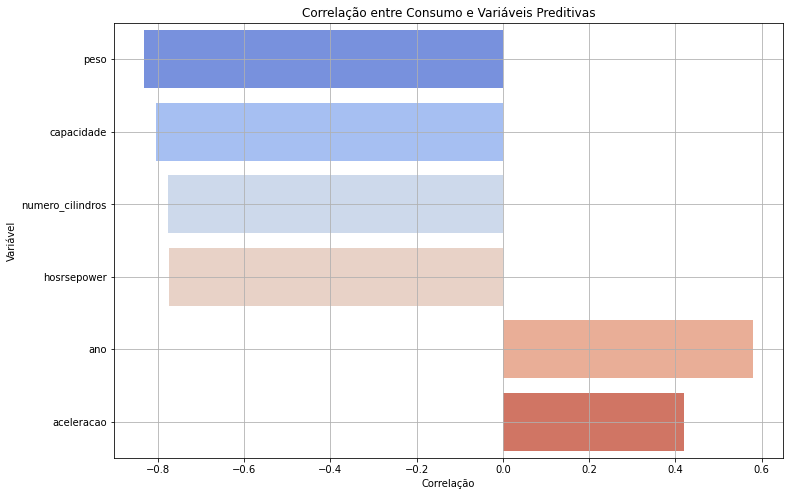

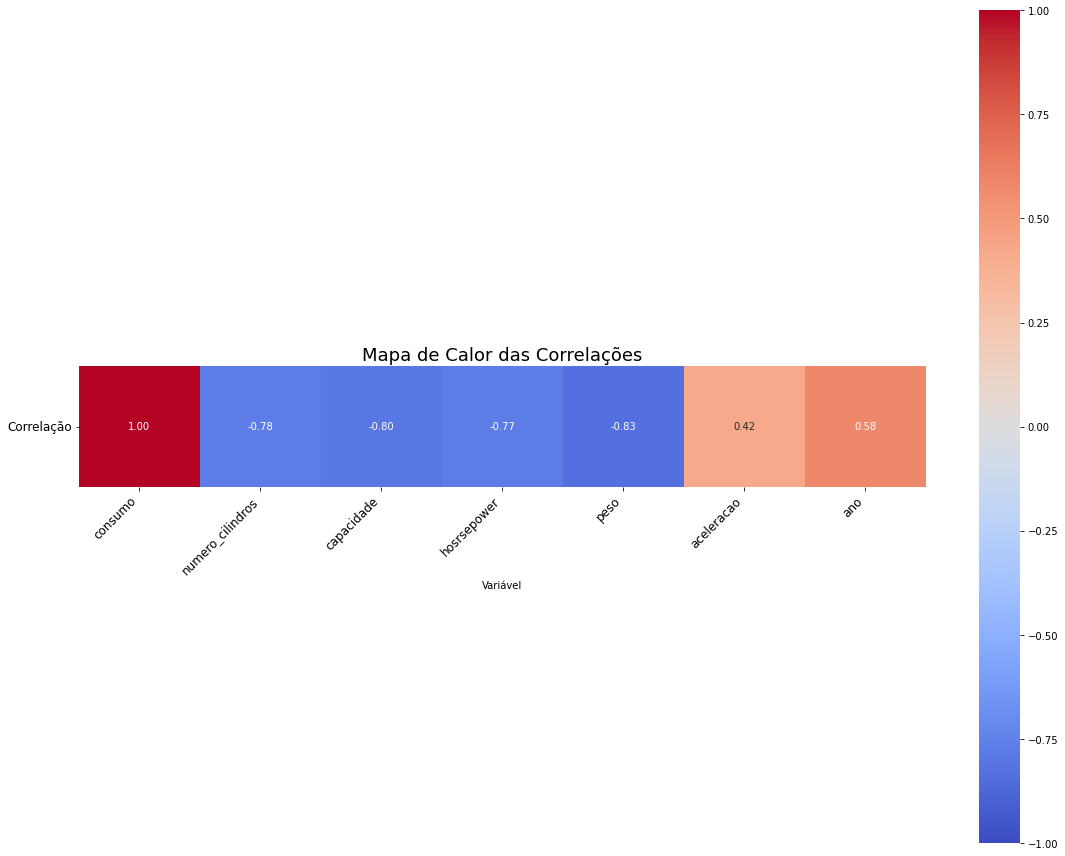

In [16]:
## Visualizando Correlação através de Gráfico

# Encontrando a correlação entre a variável target e as variáveis preditoras (exceto o nome)
correlations = {}
for col in df_carros.columns:
    if not(isinstance(df_carros.select(col).take(1)[0][0], str)):
        correlations[col] = df_carros.stat.corr('consumo', col)
        
# Convertendo o dicionário de correlações para um DataFrame Pandas
corr_df = pd.DataFrame(list(correlations.items()), columns=['Variável', 'Correlação'])

# Excluir a variável 'consumo' para o gráfico de barras
corr_df_barras = corr_df[corr_df['Variável'] != 'consumo'].copy()

# Ordenando o DataFrame por correlação absoluta para melhor visualização
corr_df_barras['Abs_Correlação'] = corr_df_barras['Correlação'].abs()
corr_df_barras = corr_df_barras.sort_values(by='Abs_Correlação', ascending=False).drop(columns='Abs_Correlação')

# Criando o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_df_barras['Correlação'], y=corr_df_barras['Variável'], palette='coolwarm')
plt.xlabel('Correlação')
plt.ylabel('Variável')
plt.title('Correlação entre Consumo e Variáveis Preditivas')
plt.grid(True)
plt.show()

# Criação do heatmap da matriz de correlação incluindo a variável 'consumo'
corr_matrix = pd.DataFrame(list(correlations.items()), columns=['Variável', 'Correlação']).set_index('Variável').T

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True, annot_kws={"size": 10})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12)
plt.title('Mapa de Calor das Correlações', fontsize=18)
plt.tight_layout()
plt.show()

<br><br>

## Resumo até aqui:

- 1. Importação de Pacotes
- 2. Preparação do Ambiente Spark
- 3. Carregamento dos Dados
  - Carregamento dos dados a partir de um arquivo CSV e criação de um RDD.
- 4. Análise Exploratória Inicial dos Dados
  - Conversão do RDD para um DataFrame Spark.
  - Conversão do DataFrame Spark para um DataFrame Pandas para facilitar a análise exploratória inicial.
  - Cria e aplica uma função para análise inicial dos dados, verificando info, valores ausentes e duplicados e caracteres especiais.
- 5. Limpeza dos Dados 
  - É criada uma função para tratamento de valores com caracteres especiais na coluna **horsepower**, substituindo '?' pelo valor arbitrário '75' e conversão de colunas para tipo numérico.
- 6. Análise Exploratória dos Dados Limpos
  - Conversão dos dados limpos (RDD dados3) para um DataFrame Spark.
  - Visualização do resumo estatístico do DataFrame Spark, convertendo-o para Pandas para melhor visualização.
- 7. Verificação da Correlação

<br> <br> <br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Engenharia de Atributos</span>

- Nesta etapa iremos **remover as colunas** que não são relevantes ou que não aparesentam correlação significativa com a variável alvo **consumo**.
- Além de remover as colunas irrelevantes, também aplicaremos a **técnica de Vetores Densos** para a criação dos vetores de características.
> (<i>Os vetores densos são mais eficientes e apropriados quando a maioria dos valores são diferentes de zero</i>).

<br>

### Removendo Colunas e Aplicando Vector Dense

Vamos excluir as variáveis **nome**, **horsepower**, **aceleracao** e **ano** sob justificativa do resultado da <i>Análise de Correlação</i> e vamos manter as colunas selecionadas através do vetor denso.

Para isso, vamos definir uma função que transforma cada linha do RDD, mantendo apenas as variáveis relevantes (peso, capacidade, numero_cilindros) em um vetor denso:

In [17]:
## Convertendo para um LabeledPoint (target, Vector[features])

# Seleciona as variáveis relevantes para o modelo
def transformaVar(row) :
    obj = (row["consumo"], Vectors.dense([row["peso"], row["capacidade"], row["numero_cilindros"]]))
    return obj

# Aplica a função no RDD e cria outro objeto RDD somente com as variáveis
dados4 = dados3.map(transformaVar)

# Visualiza
dados4.take(5)

[(30.0, DenseVector([2074.0, 79.0, 4.0])),
 (30.0, DenseVector([2065.0, 88.0, 4.0])),
 (31.0, DenseVector([1773.0, 71.0, 4.0])),
 (35.0, DenseVector([1613.0, 72.0, 4.0])),
 (27.0, DenseVector([1834.0, 97.0, 4.0]))]

#### Convertendo Para Objeto Pandas Apenas Para Visualização

In [18]:
# Converter o RDD dados4 para DataFrame Spark
rows = dados4.map(lambda x: Row(consumo=x[0], features=x[1])) # Mapeia os dados para Rows
 
# Cria um DataFrame a partir das Rows
df_carros_final = spSession.createDataFrame(rows)
#df_carros_final.show(5)

# Passo 2: Converter o DataFrame Spark para DataFrame Pandas
df_pandas_final = df_carros_final.toPandas()
display(df_pandas_final.head())

,consumo,features
0,30.0,"[2074.0, 79.0, 4.0]"
1,30.0,"[2065.0, 88.0, 4.0]"
2,31.0,"[1773.0, 71.0, 4.0]"
3,35.0,"[1613.0, 72.0, 4.0]"
4,27.0,"[1834.0, 97.0, 4.0]"


<br>

# Convertendo Para Objeto Dataframe PySpark

- Transformar o RDD em um DataFrame do PySpark para facilitar a aplicação de técnicas de Machine Learning.

> Essa conversão é essencial para utilizar os métodos e algoritmos de Machine Learning disponíveis no PySpark.

#### Estrutura do DataFrame

- **label**: A variável alvo que queremos prever, neste caso, o consumo de combustível.
- **features**: Vetor denso contendo as características selecionadas (peso, capacidade, número de cilindros).

#### Nota sobre o nome 'label':

> Não é obrigatório usar o nome **'label'** para a variável alvo. No entanto, 'label' é uma convenção comum, especialmente quando se utiliza as bibliotecas de Machine Learning do PySpark, que esperam encontrar uma coluna com este nome por padrão. Utilizar 'label' facilita a integração e aplicação de modelos predefinidos no PySpark.

In [19]:
# Converte o RDD para DataFrame do Spark
df_carros = spSession.createDataFrame(dados4, ["label", "features"])

# Visualiza DataFrame do Spark
df_carros.show(10)

+-----+------------------+
|label|          features|
+-----+------------------+
| 30.0| [2074.0,79.0,4.0]|
| 30.0| [2065.0,88.0,4.0]|
| 31.0| [1773.0,71.0,4.0]|
| 35.0| [1613.0,72.0,4.0]|
| 27.0| [1834.0,97.0,4.0]|
| 26.0| [1955.0,91.0,4.0]|
| 24.0|[2278.0,113.0,4.0]|
| 25.0| [2126.0,97.5,4.0]|
| 23.0| [2254.0,97.0,4.0]|
| 20.0|[2408.0,140.0,4.0]|
+-----+------------------+
only showing top 10 rows



<br><br><br><br>

# Pré-Processamento de Dados Para Construção de Modelos de Machine Learning

<br><br>


## Dividindo os dados em Dados de Treino e Dados de Teste
- Nós **treinamos** o modelo com **dados de treino** e **avaliamos** o modelo com **dados de teste**.

<br>

In [20]:
# Divisão em dados de treino e teste
dados_treino, dados_teste = df_carros.randomSplit([.7,.3], seed = rnd_seed)

print(dados_treino.count())
print(dados_teste.count())

284
114


In [21]:
dados_treino.show(5)

+-----+------------------+
|label|          features|
+-----+------------------+
| 10.0|[4376.0,307.0,8.0]|
| 10.0|[4615.0,360.0,8.0]|
| 11.0|[3664.0,350.0,8.0]|
| 11.0|[4633.0,429.0,8.0]|
| 11.0|[4997.0,400.0,8.0]|
+-----+------------------+
only showing top 5 rows



<br>

## Tratamento de Escala

#### Aplicando Ténica de Padronização

- Será criada uma nova coluna chamada **scaled_features** que contém os dados da coluna **features** padronizados.

In [22]:
from pyspark.ml.feature import StandardScaler

# Criação do objeto StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Ajustar o StandardScaler com os dados de treino
scaler_model = scaler.fit(dados_treino)

# Transformar os dados de treino e teste
dados_treino = scaler_model.transform(dados_treino)
dados_teste = scaler_model.transform(dados_teste)

# Mostrar algumas linhas dos dados escalonados
dados_treino.show(5)

+-----+------------------+--------------------+
|label|          features|     scaled_features|
+-----+------------------+--------------------+
| 10.0|[4376.0,307.0,8.0]|[1.74530389791523...|
| 10.0|[4615.0,360.0,8.0]|[2.03755997516046...|
| 11.0|[3664.0,350.0,8.0]|[0.87464981005493...|
| 11.0|[4633.0,429.0,8.0]|[2.05957089311199...|
| 11.0|[4997.0,400.0,8.0]|[2.50468056724281...|
+-----+------------------+--------------------+
only showing top 5 rows



In [23]:
dados_teste.show(5)

+-----+------------------+--------------------+
|label|          features|     scaled_features|
+-----+------------------+--------------------+
|  9.0|[4732.0,304.0,8.0]|[2.18063094184537...|
| 11.0|[4382.0,318.0,8.0]|[1.75264087056573...|
| 12.0|[4456.0,350.0,8.0]|[1.84313019992200...|
| 12.0|[4499.0,350.0,8.0]|[1.89571183725064...|
| 12.0|[4952.0,429.0,8.0]|[2.44965327236400...|
+-----+------------------+--------------------+
only showing top 5 rows



<br><br><br><br><br>

<span style="color: green; font-size: 40px; font-weight: bold;">Construindo Modelos de Machine Learning</span>

<br>

- Nesta etapa do projeto o ideal é escolher um algoritmo simples e fácil de compreender, que será usado como Benchmark (modelo base).

#### Importante

- Iremos treinar dois conjuntos de dados: um **conjunto de dados sem tratamento de escala** e outro **com tratamento de escala**.

<br><br><br>

## Criando Dataframe para salvar métricas de cada Modelo

In [24]:
# Cria um dataframe para receber as métricas de cada modelo
df_modelos = pd.DataFrame()

<br><br><br>

# <span style="color: green; font-weight: bold;">Modelo 1 com Regressão Linear (Benchmark)</span>

<br>

> # Versão 1

- Sem Ajuste de Hiperparâmetros.
- Utiliza Coluna **features** e habilita **standardization**.

<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [29]:
# Criação e Treinamento
modelo_lr_v1 = LinearRegression(featuresCol='features', 
                                labelCol='label', 
                                predictionCol='Predicted_price', 
                                maxIter=100, 
                                regParam=0.3, 
                                elasticNetParam=0.8, 
                                standardization=True)

modelo_v1 = modelo_lr_v1.fit(dados_treino)
modelo_v1

LinearRegressionModel: uid=LinearRegression_1224e70187fc, numFeatures=3

+------------------+-----+
|   Predicted_price|label|
+------------------+-----+
|10.813839921567123|  9.0|
|12.937730401703075| 11.0|
+------------------+-----+
only showing top 2 rows

Mean Absolute Error (MAE) nos dados de teste: 3.018614577902183
Root Mean Squared Error (RMSE) nos dados de teste = 3.7788264273002263


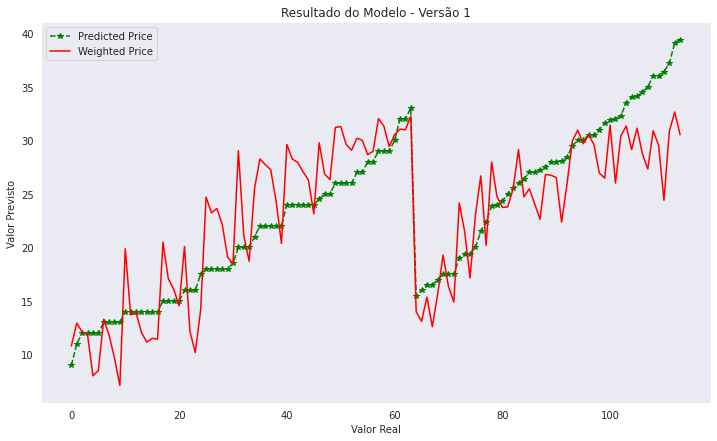

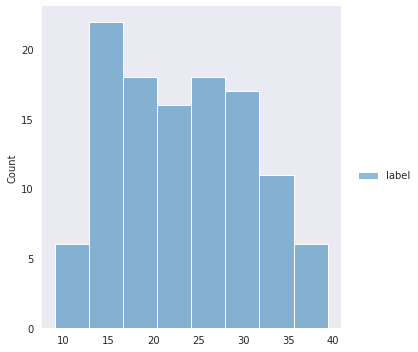

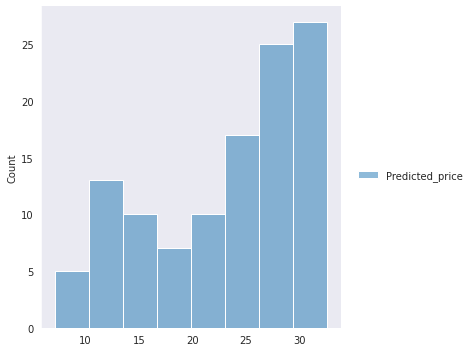


Avaliação do Modelo (Versão 1)

MAE - Erro Médio Absoluto: 3.018614577902184
MSE - Erro Quadrático Médio: 14.279529167662599
RMSE - Raiz Quadrada do Erro Quadrático Médio: 3.778826427300227
Coeficiente R2: 0.7308683456219165
Variância Explicada: 0.7311386732456002


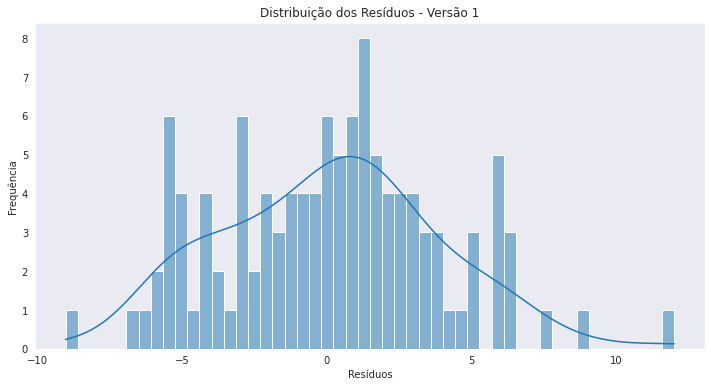

In [30]:
# Previsões
previsoes_v1 = modelo_v1.transform(dados_teste)
previsoes_v1.select("Predicted_price", "label").show(2)

# Avaliações
mae_v1 = previsoes_v1.selectExpr("avg(abs(Predicted_price - label)) as mae").collect()[0]["mae"]
print(f"Mean Absolute Error (MAE) nos dados de teste: {mae_v1}")

evaluator_v1 = RegressionEvaluator(labelCol="label", predictionCol="Predicted_price", metricName="rmse")
rmse_v1 = evaluator_v1.evaluate(previsoes_v1)
print(f"Root Mean Squared Error (RMSE) nos dados de teste = {rmse_v1}")

# Extração e plotagem das previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste)
Y_v1 = pred_results_v1.predictions.select('label').toPandas()
_Y_v1 = pred_results_v1.predictions.select("Predicted_price").toPandas()

plt.figure(figsize=(12, 7))
plt.plot(Y_v1, color='green', marker='*', linestyle='dashed', label='Predicted Price')
plt.plot(_Y_v1, color='red', label='Weighted Price')
plt.title('Resultado do Modelo - Versão 1')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

sns.set_style("dark")
sns.displot(Y_v1, color="r", label="Valores Reais")
sns.displot(_Y_v1, color="b", label="Valores Previstos")
plt.show()

# Avaliação do Modelo
mae_v1 = mean_absolute_error(Y_v1, _Y_v1)
mse_v1 = mean_squared_error(Y_v1, _Y_v1)
rmse_v1 = np.sqrt(mse_v1)
r2_v1 = r2_score(Y_v1, _Y_v1)
evs_v1 = explained_variance_score(Y_v1, _Y_v1)

print('\nAvaliação do Modelo (Versão 1)\n')
print(f'MAE - Erro Médio Absoluto: {mae_v1}')
print(f'MSE - Erro Quadrático Médio: {mse_v1}')
print(f'RMSE - Raiz Quadrada do Erro Quadrático Médio: {rmse_v1}')
print(f'Coeficiente R2: {r2_v1}')
print(f'Variância Explicada: {evs_v1}')

# Análise de Resíduos
residuos_v1 = Y_v1['label'] - _Y_v1['Predicted_price']
df_residuos_v1 = pd.DataFrame({'label': Y_v1['label'], 'Predicted_price': _Y_v1['Predicted_price'], 'Residuo': residuos_v1})

plt.figure(figsize=(12, 6))
sns.histplot(df_residuos_v1['Residuo'], bins=50, kde=True)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos - Versão 1')
plt.show()

<br>

### Salvando as Métricas

In [31]:
# Salvando as Métricas
modelo_v1_metrics = pd.DataFrame({
    'Nome do Modelo': ['Regressão Linear'],
    'Versao': ['1'],
    'Tipo de Dados': ['Original'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'MAE': [f"{mae_v1:.2f}"],
    'MSE': [f"{mse_v1:.2f}"],
    'RMSE': [rmse_v1],
    'Coeficiente R2': [r2_v1],
    'Variância Explicada': [evs_v1]
})

df_modelos = pd.concat([df_modelos, modelo_v1_metrics], ignore_index=True)
display(df_modelos)

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,MAE,MSE,RMSE,Coeficiente R2,Variância Explicada
0,Regressão Linear,1,Original,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778826,0.730868,0.731139


<br>

> # Versão 2

- Sem Ajuste de Hiperparâmetros.
- Utiliza Coluna **scaled_features** e desabilita **standardization**.

<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [32]:
# Criação e Treinamento
modelo_lr_v2 = LinearRegression(featuresCol='scaled_features', 
                                labelCol='label', 
                                predictionCol='Predicted_price', 
                                maxIter=100, 
                                regParam=0.3, 
                                elasticNetParam=0.8, 
                                standardization=False)

modelo_v2 = modelo_lr_v2.fit(dados_treino)
modelo_v2

LinearRegressionModel: uid=LinearRegression_bd30d40cec33, numFeatures=3

+------------------+-----+
|   Predicted_price|label|
+------------------+-----+
|10.815572861574015|  9.0|
| 12.93891942158486| 11.0|
|12.108058954843301| 12.0|
|11.828400335396314| 12.0|
| 8.019185172796368| 12.0|
| 8.502206128574239| 12.0|
|13.291730320874738| 13.0|
|11.808889268923267| 13.0|
| 9.675758736813831| 13.0|
| 7.113305340020506| 13.0|
+------------------+-----+
only showing top 10 rows

Mean Absolute Error (MAE) nos dados de teste: 3.0183992059616616
Root Mean Squared Error (RMSE) nos dados de teste = 3.778642612255191


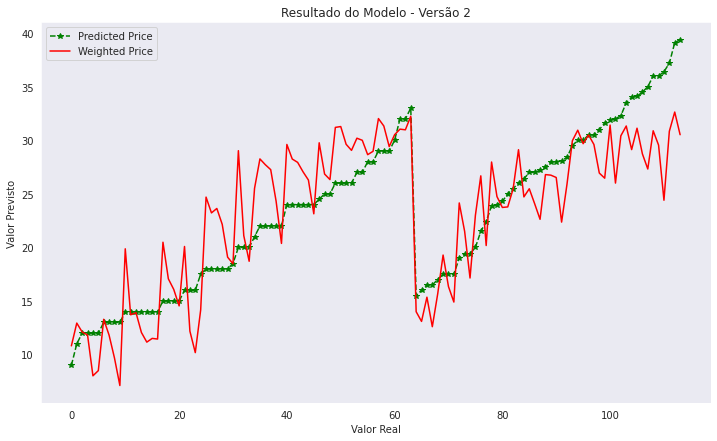

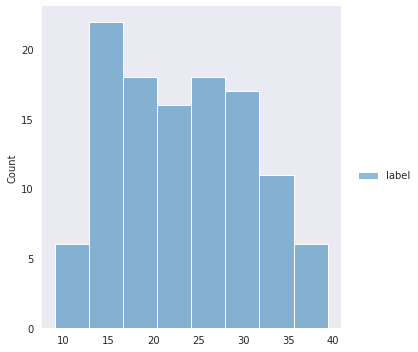

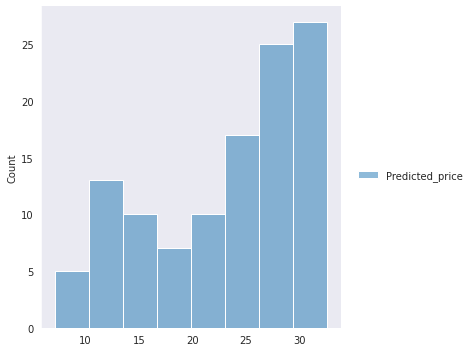


Avaliação do Modelo (Versão 2)

MAE - Erro Médio Absoluto: 3.0183992059616616
MSE - Erro Quadrático Médio: 14.27813999115073
RMSE - Raiz Quadrada do Erro Quadrático Médio: 3.7786426122551906
Coeficiente R2: 0.7308945279538739
Variância Explicada: 0.731164526466809


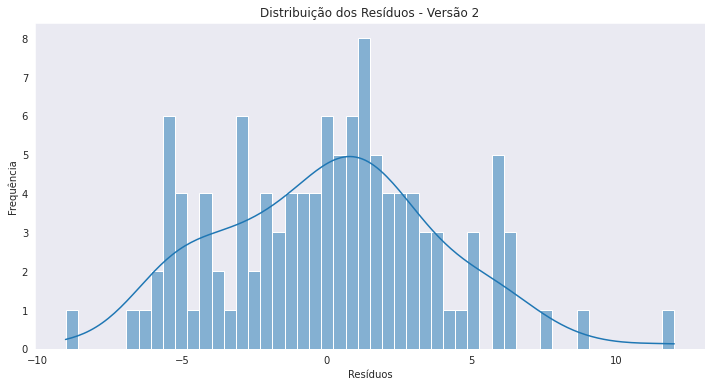

In [33]:
# Previsões
previsoes_v2 = modelo_v2.transform(dados_teste)
previsoes_v2.select("Predicted_price", "label").show(10)

# Avaliações
mae_v2 = previsoes_v2.selectExpr("avg(abs(Predicted_price - label)) as mae").collect()[0]["mae"]
print(f"Mean Absolute Error (MAE) nos dados de teste: {mae_v2}")

evaluator_v2 = RegressionEvaluator(labelCol="label", predictionCol="Predicted_price", metricName="rmse")
rmse_v2 = evaluator_v2.evaluate(previsoes_v2)
print(f"Root Mean Squared Error (RMSE) nos dados de teste = {rmse_v2}")

# Extração e plotagem das previsões
pred_results_v2 = modelo_v2.evaluate(dados_teste)
Y_v2 = pred_results_v2.predictions.select('label').toPandas()
_Y_v2 = pred_results_v2.predictions.select("Predicted_price").toPandas()

plt.figure(figsize=(12, 7))
plt.plot(Y_v2, color='green', marker='*', linestyle='dashed', label='Predicted Price')
plt.plot(_Y_v2, color='red', label='Weighted Price')
plt.title('Resultado do Modelo - Versão 2')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

sns.set_style("dark")
sns.displot(Y_v2, color="r", label="Valores Reais")
sns.displot(_Y_v2, color="b", label="Valores Previstos")
plt.show()

# Avaliação do Modelo
mae_v2 = mean_absolute_error(Y_v2, _Y_v2)
mse_v2 = mean_squared_error(Y_v2, _Y_v2)
rmse_v2 = np.sqrt(mse_v2)
r2_v2 = r2_score(Y_v2, _Y_v2)
evs_v2 = explained_variance_score(Y_v2, _Y_v2)

print('\nAvaliação do Modelo (Versão 2)\n')
print(f'MAE - Erro Médio Absoluto: {mae_v2}')
print(f'MSE - Erro Quadrático Médio: {mse_v2}')
print(f'RMSE - Raiz Quadrada do Erro Quadrático Médio: {rmse_v2}')
print(f'Coeficiente R2: {r2_v2}')
print(f'Variância Explicada: {evs_v2}')

# Análise de Resíduos
residuos_v2 = Y_v2['label'] - _Y_v2['Predicted_price']
df_residuos_v2 = pd.DataFrame({'label': Y_v2['label'], 'Predicted_price': _Y_v2['Predicted_price'], 'Residuo': residuos_v2})

plt.figure(figsize=(12, 6))
sns.histplot(df_residuos_v2['Residuo'], bins=50, kde=True)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos - Versão 2')
plt.show()

<br>

### Salvando as Métricas

In [34]:
# Salvando as Métricas
modelo_v2_metrics = pd.DataFrame({
    'Nome do Modelo': ['Regressão Linear'],
    'Versao': ['2'],
    'Tipo de Dados': ['Escalonados'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'MAE': [f"{mae_v2:.2f}"],
    'MSE': [f"{mse_v2:.2f}"],
    'RMSE': [rmse_v2],
    'Coeficiente R2': [r2_v2],
    'Variância Explicada': [evs_v2]
})

df_modelos = pd.concat([df_modelos, modelo_v2_metrics], ignore_index=True)
display(df_modelos)

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,MAE,MSE,RMSE,Coeficiente R2,Variância Explicada
0,Regressão Linear,1,Original,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778826,0.730868,0.731139
1,Regressão Linear,2,Escalonados,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778643,0.730895,0.731165


<br>

> # Versão 3

- Com Ajuste de Hiperparâmetros.
- Utiliza Coluna **features** e desabilita **standardization**.

<br>


### Configurando Hiperparâmetros

In [38]:
# Configuração de Hiperparâmetros
modelo_lr_v3 = LinearRegression(featuresCol='features', 
                                labelCol='label', 
                                predictionCol='Predicted_price', 
                                standardization=True)

grid_v3 = ParamGridBuilder().addGrid(modelo_lr_v3.maxIter, [50, 100]).build()
evaluator_v3 = RegressionEvaluator(labelCol="label", predictionCol="Predicted_price", metricName="rmse")
cv_v3 = CrossValidator(estimator=modelo_lr_v3, estimatorParamMaps=grid_v3, evaluator=evaluator_v3, parallelism=2)
cv_v3

CrossValidator_8ca7a6585d79

<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [39]:
# Treinamento
cvModel_v3 = cv_v3.fit(dados_treino)
modelo_v3 = cvModel_v3.bestModel
modelo_v3

LinearRegressionModel: uid=LinearRegression_f43cd509a3a2, numFeatures=3

+------------------+-----+
|   Predicted_price|label|
+------------------+-----+
|10.087009241496055|  9.0|
|12.395126400932206| 11.0|
|11.570543713028947| 12.0|
| 11.27041556743383| 12.0|
| 7.348020327459146| 12.0|
| 7.769950594239461| 12.0|
|12.840853538571096| 13.0|
|11.249476394485328| 13.0|
| 9.065043835548728| 13.0|
| 6.315032454979473| 13.0|
+------------------+-----+
only showing top 10 rows

Mean Absolute Error (MAE) nos dados de teste: 3.1267705192972746
Root Mean Squared Error (RMSE) nos dados de teste = 3.8706227479599074


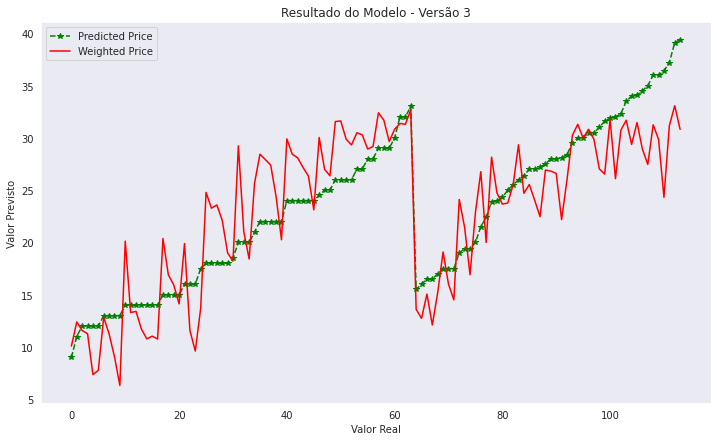

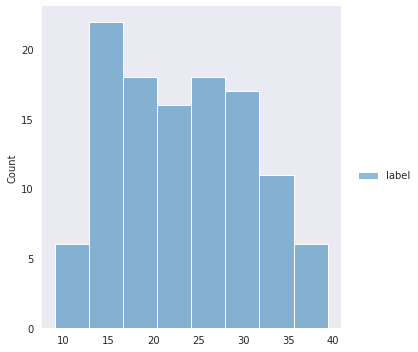

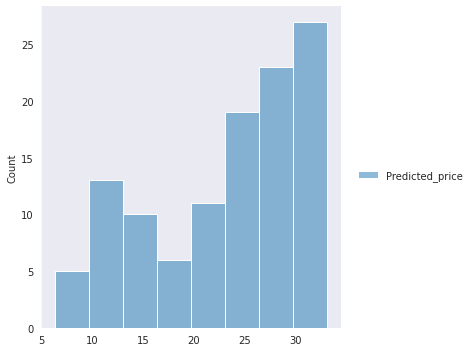


Avaliação do Modelo (Versão 3)

MAE - Erro Médio Absoluto: 3.1267705192972746
MSE - Erro Quadrático Médio: 14.9817204570247
RMSE - Raiz Quadrada do Erro Quadrático Médio: 3.870622747959907
Coeficiente R2: 0.717633882413993
Variância Explicada: 0.718055454454511


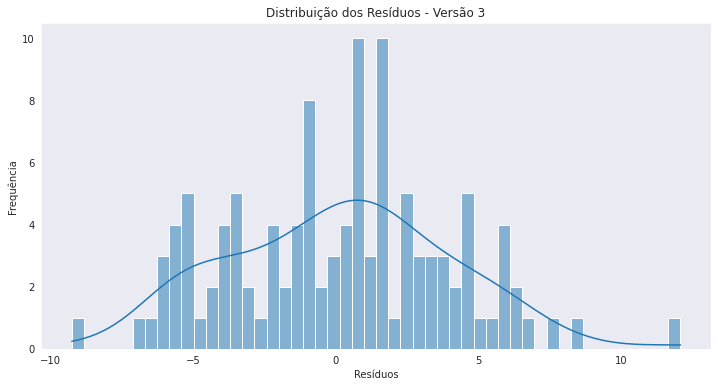

In [40]:
# Previsões
previsoes_v3 = modelo_v3.transform(dados_teste)
previsoes_v3.select("Predicted_price", "label").show(10)

# Avaliações
mae_v3 = previsoes_v3.selectExpr("avg(abs(Predicted_price - label)) as mae").collect()[0]["mae"]
print(f"Mean Absolute Error (MAE) nos dados de teste: {mae_v3}")

rmse_v3 = evaluator_v3.evaluate(previsoes_v3)
print(f"Root Mean Squared Error (RMSE) nos dados de teste = {rmse_v3}")

# Extração e plotagem das previsões
pred_results_v3 = modelo_v3.evaluate(dados_teste)
Y_v3 = pred_results_v3.predictions.select('label').toPandas()
_Y_v3 = pred_results_v3.predictions.select("Predicted_price").toPandas()

plt.figure(figsize=(12, 7))
plt.plot(Y_v3, color='green', marker='*', linestyle='dashed', label='Predicted Price')
plt.plot(_Y_v3, color='red', label='Weighted Price')
plt.title('Resultado do Modelo - Versão 3')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

sns.set_style("dark")
sns.displot(Y_v3, color="r", label="Valores Reais")
sns.displot(_Y_v3, color="b", label="Valores Previstos")
plt.show()

# Avaliação do Modelo
mae_v3 = mean_absolute_error(Y_v3, _Y_v3)
mse_v3 = mean_squared_error(Y_v3, _Y_v3)
rmse_v3 = np.sqrt(mse_v3)
r2_v3 = r2_score(Y_v3, _Y_v3)
evs_v3 = explained_variance_score(Y_v3, _Y_v3)

print('\nAvaliação do Modelo (Versão 3)\n')
print(f'MAE - Erro Médio Absoluto: {mae_v3}')
print(f'MSE - Erro Quadrático Médio: {mse_v3}')
print(f'RMSE - Raiz Quadrada do Erro Quadrático Médio: {rmse_v3}')
print(f'Coeficiente R2: {r2_v3}')
print(f'Variância Explicada: {evs_v3}')

# Análise de Resíduos
residuos_v3 = Y_v3['label'] - _Y_v3['Predicted_price']
df_residuos_v3 = pd.DataFrame({'label': Y_v3['label'], 'Predicted_price': _Y_v3['Predicted_price'], 'Residuo': residuos_v3})

plt.figure(figsize=(12, 6))
sns.histplot(df_residuos_v3['Residuo'], bins=50, kde=True)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos - Versão 3')
plt.show()

<br>

### Salvando as Métricas

In [41]:
# Salvando as Métricas
modelo_v3_metrics = pd.DataFrame({
    'Nome do Modelo': ['Regressão Linear'],
    'Versao': ['3'],
    'Tipo de Dados': ['Original'],
    'Tipo de Modelo': ['Com Ajuste de Hiperparâmetros'], 
    'MAE': [f"{mae_v3:.2f}"],
    'MSE': [f"{mse_v3:.2f}"],
    'RMSE': [rmse_v3],
    'Coeficiente R2': [r2_v3],
    'Variância Explicada': [evs_v3]
})

df_modelos = pd.concat([df_modelos, modelo_v3_metrics], ignore_index=True)
display(df_modelos)

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,MAE,MSE,RMSE,Coeficiente R2,Variância Explicada
0,Regressão Linear,1,Original,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778826,0.730868,0.731139
1,Regressão Linear,2,Escalonados,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778643,0.730895,0.731165
2,Regressão Linear,3,Original,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055


<br>

> # Versão 4

- Com Ajuste de Hiperparâmetros.
- Utiliza Coluna **scaled_features** e desabilita **standardization**.

<br>


### Configurando Hiperparâmetros

In [42]:
# Configuração de Hiperparâmetros
modelo_lr_v4 = LinearRegression(featuresCol='scaled_features', 
                                labelCol='label', 
                                predictionCol='Predicted_price', 
                                standardization=False)

grid_v4 = ParamGridBuilder().addGrid(modelo_lr_v4.maxIter, [50, 100]).build()
evaluator_v4 = RegressionEvaluator(labelCol="label", predictionCol="Predicted_price", metricName="rmse")
cv_v4 = CrossValidator(estimator=modelo_lr_v4, estimatorParamMaps=grid_v4, evaluator=evaluator_v4, parallelism=2)
cv_v4

CrossValidator_a4c6fadfbd07

<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [43]:
# Treinamento
cvModel_v4 = cv_v4.fit(dados_treino)
modelo_v4 = cvModel_v4.bestModel
modelo_v4

LinearRegressionModel: uid=LinearRegression_33699b3a2121, numFeatures=3

+------------------+-----+
|   Predicted_price|label|
+------------------+-----+
|10.087009241495931|  9.0|
|12.395126400932176| 11.0|
| 11.57054371302893| 12.0|
|  11.2704155674338| 12.0|
| 7.348020327459082| 12.0|
| 7.769950594239361| 12.0|
|12.840853538571114| 13.0|
|11.249476394485301| 13.0|
| 9.065043835548689| 13.0|
| 6.315032454979349| 13.0|
+------------------+-----+
only showing top 10 rows

Mean Absolute Error (MAE) nos dados de teste: 3.1267705192972883
Root Mean Squared Error (RMSE) nos dados de teste = 3.870622747959926


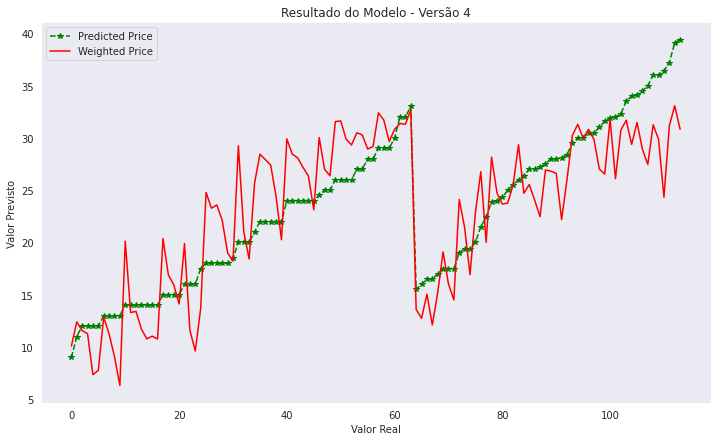

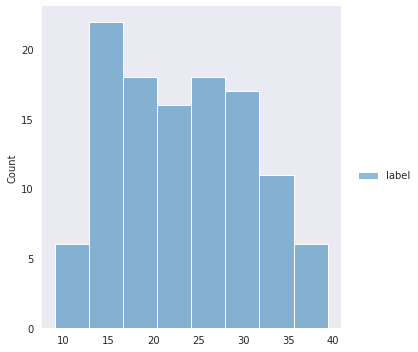

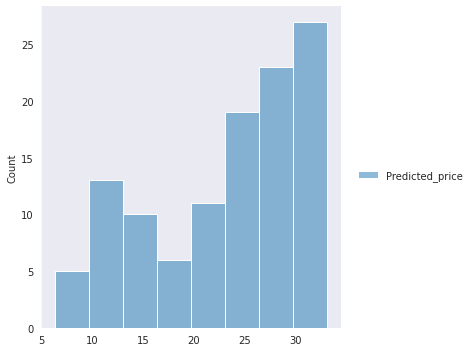


Avaliação do Modelo (Versão 4)

MAE - Erro Médio Absoluto: 3.1267705192972883
MSE - Erro Quadrático Médio: 14.98172045702485
RMSE - Raiz Quadrada do Erro Quadrático Médio: 3.870622747959926
Coeficiente R2: 0.7176338824139902
Variância Explicada: 0.7180554544545084


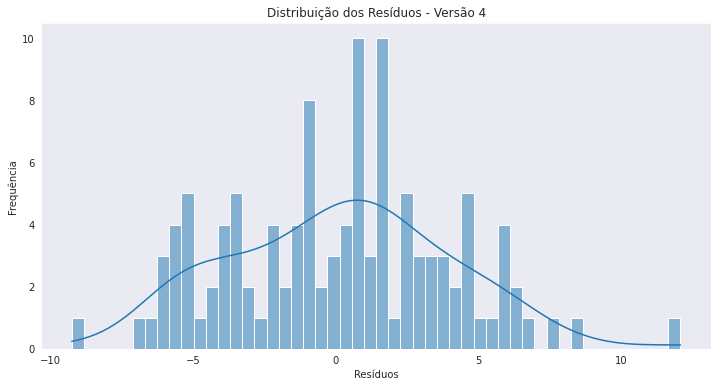

In [44]:
# Previsões
previsoes_v4 = modelo_v4.transform(dados_teste)
previsoes_v4.select("Predicted_price", "label").show(10)

# Avaliações
mae_v4 = previsoes_v4.selectExpr("avg(abs(Predicted_price - label)) as mae").collect()[0]["mae"]
print(f"Mean Absolute Error (MAE) nos dados de teste: {mae_v4}")

rmse_v4 = evaluator_v4.evaluate(previsoes_v4)
print(f"Root Mean Squared Error (RMSE) nos dados de teste = {rmse_v4}")

# Extração e plotagem das previsões
pred_results_v4 = modelo_v4.evaluate(dados_teste)
Y_v4 = pred_results_v4.predictions.select('label').toPandas()
_Y_v4 = pred_results_v4.predictions.select("Predicted_price").toPandas()

plt.figure(figsize=(12, 7))
plt.plot(Y_v4, color='green', marker='*', linestyle='dashed', label='Predicted Price')
plt.plot(_Y_v4, color='red', label='Weighted Price')
plt.title('Resultado do Modelo - Versão 4')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

sns.set_style("dark")
sns.displot(Y_v4, color="r", label="Valores Reais")
sns.displot(_Y_v4, color="b", label="Valores Previstos")
plt.show()

# Avaliação do Modelo
mae_v4 = mean_absolute_error(Y_v4, _Y_v4)
mse_v4 = mean_squared_error(Y_v4, _Y_v4)
rmse_v4 = np.sqrt(mse_v4)
r2_v4 = r2_score(Y_v4, _Y_v4)
evs_v4 = explained_variance_score(Y_v4, _Y_v4)

print('\nAvaliação do Modelo (Versão 4)\n')
print(f'MAE - Erro Médio Absoluto: {mae_v4}')
print(f'MSE - Erro Quadrático Médio: {mse_v4}')
print(f'RMSE - Raiz Quadrada do Erro Quadrático Médio: {rmse_v4}')
print(f'Coeficiente R2: {r2_v4}')
print(f'Variância Explicada: {evs_v4}')

# Análise de Resíduos
residuos_v4 = Y_v4['label'] - _Y_v4['Predicted_price']
df_residuos_v4 = pd.DataFrame({'label': Y_v4['label'], 'Predicted_price': _Y_v4['Predicted_price'], 'Residuo': residuos_v4})

plt.figure(figsize=(12, 6))
sns.histplot(df_residuos_v4['Residuo'], bins=50, kde=True)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos - Versão 4')
plt.show()

<br>

### Salvando as Métricas

In [45]:
# Salvando as Métricas
modelo_v4_metrics = pd.DataFrame({
    'Nome do Modelo': ['Regressão Linear'],
    'Versao': ['4'],
    'Tipo de Dados': ['Escalonados'],
    'Tipo de Modelo': ['Com Ajuste de Hiperparâmetros'], 
    'MAE': [f"{mae_v4:.2f}"],
    'MSE': [f"{mse_v4:.2f}"],
    'RMSE': [rmse_v4],
    'Coeficiente R2': [r2_v4],
    'Variância Explicada': [evs_v4]
})

df_modelos = pd.concat([df_modelos, modelo_v4_metrics], ignore_index=True)
display(df_modelos)

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,MAE,MSE,RMSE,Coeficiente R2,Variância Explicada
0,Regressão Linear,1,Original,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778826,0.730868,0.731139
1,Regressão Linear,2,Escalonados,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778643,0.730895,0.731165
2,Regressão Linear,3,Original,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055
3,Regressão Linear,4,Escalonados,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055


<br><br><br>

# <span style="color: green; font-weight: bold;">Modelo 2 com Decision Tree Regressor</span>

<br>

> # Versão 1

- Sem Ajuste de Hiperparâmetros.
- Utiliza Coluna **scaled_features**.

<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

+------------------+-----+
|   Predicted_price|label|
+------------------+-----+
|              13.5|  9.0|
|13.655555555555553| 11.0|
|13.655555555555553| 12.0|
|13.655555555555553| 12.0|
|11.714285714285714| 12.0|
|11.714285714285714| 12.0|
|             14.64| 13.0|
|13.655555555555553| 13.0|
|11.714285714285714| 13.0|
|11.714285714285714| 13.0|
+------------------+-----+
only showing top 10 rows

Mean Absolute Error (MAE) nos dados de teste: 3.1168369621681196
Root Mean Squared Error (RMSE) nos dados de teste = 4.167666720790919


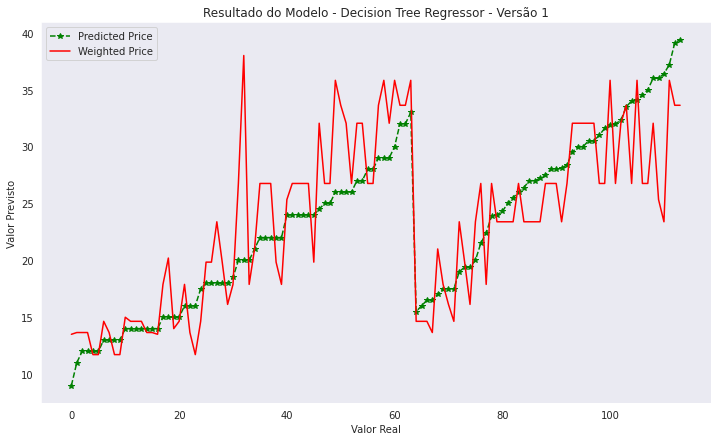

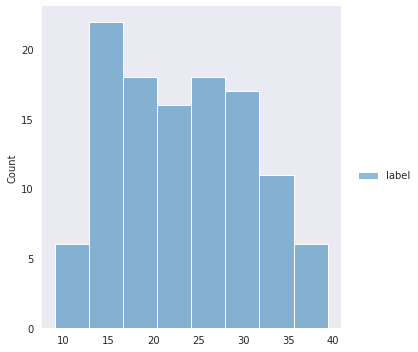

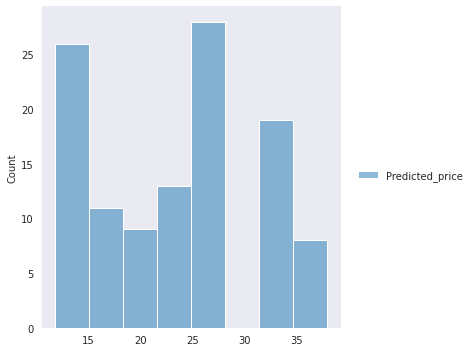


Avaliação do Modelo (Decision Tree Regressor - Versão 1)

MAE - Erro Médio Absoluto: 3.116836962168119
MSE - Erro Quadrático Médio: 17.369445895588136
RMSE - Raiz Quadrada do Erro Quadrático Médio: 4.167666720790919
Coeficiente R2: 0.6726315234471111
Variância Explicada: 0.6747370720962051


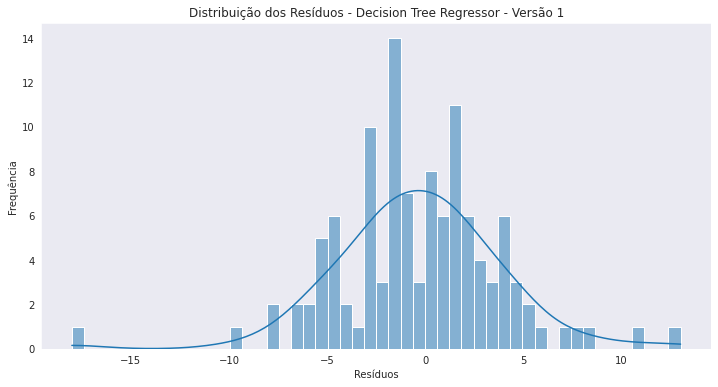

In [48]:
# Criação e Treinamento
modelo_dt_v1 = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='label', predictionCol='Predicted_price')
modelo_v1_dt = modelo_dt_v1.fit(dados_treino)

# Previsões
previsoes_v1_dt = modelo_v1_dt.transform(dados_teste)
previsoes_v1_dt.select("Predicted_price", "label").show(10)

# Avaliações
mae_v1_dt = previsoes_v1_dt.selectExpr("avg(abs(Predicted_price - label)) as mae").collect()[0]["mae"]
print(f"Mean Absolute Error (MAE) nos dados de teste: {mae_v1_dt}")

evaluator_v1_dt = RegressionEvaluator(labelCol="label", predictionCol="Predicted_price", metricName="rmse")
rmse_v1_dt = evaluator_v1_dt.evaluate(previsoes_v1_dt)
print(f"Root Mean Squared Error (RMSE) nos dados de teste = {rmse_v1_dt}")

# Extração e plotagem das previsões
Y_v1_dt = previsoes_v1_dt.select('label').toPandas()
_Y_v1_dt = previsoes_v1_dt.select("Predicted_price").toPandas()

plt.figure(figsize=(12, 7))
plt.plot(Y_v1_dt, color='green', marker='*', linestyle='dashed', label='Predicted Price')
plt.plot(_Y_v1_dt, color='red', label='Weighted Price')
plt.title('Resultado do Modelo - Decision Tree Regressor - Versão 1')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

sns.set_style("dark")
sns.displot(Y_v1_dt, color="r", label="Valores Reais")
sns.displot(_Y_v1_dt, color="b", label="Valores Previstos")
plt.show()

# Avaliação do Modelo
mae_v1_dt = mean_absolute_error(Y_v1_dt, _Y_v1_dt)
mse_v1_dt = mean_squared_error(Y_v1_dt, _Y_v1_dt)
rmse_v1_dt = np.sqrt(mse_v1_dt)
r2_v1_dt = r2_score(Y_v1_dt, _Y_v1_dt)
evs_v1_dt = explained_variance_score(Y_v1_dt, _Y_v1_dt)

print('\nAvaliação do Modelo (Decision Tree Regressor - Versão 1)\n')
print(f'MAE - Erro Médio Absoluto: {mae_v1_dt}')
print(f'MSE - Erro Quadrático Médio: {mse_v1_dt}')
print(f'RMSE - Raiz Quadrada do Erro Quadrático Médio: {rmse_v1_dt}')
print(f'Coeficiente R2: {r2_v1_dt}')
print(f'Variância Explicada: {evs_v1_dt}')

# Análise de Resíduos
residuos_v1_dt = Y_v1_dt['label'] - _Y_v1_dt['Predicted_price']
df_residuos_v1_dt = pd.DataFrame({'label': Y_v1_dt['label'], 'Predicted_price': _Y_v1_dt['Predicted_price'], 'Residuo': residuos_v1_dt})

plt.figure(figsize=(12, 6))
sns.histplot(df_residuos_v1_dt['Residuo'], bins=50, kde=True)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos - Decision Tree Regressor - Versão 1')
plt.show()

In [49]:
# Salvando as Métricas
modelo_v1_dt_metrics = pd.DataFrame({
    'Nome do Modelo': ['Decision Tree Regressor'],
    'Versao': ['1'],
    'Tipo de Dados': ['Escalonados'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'MAE': [f"{mae_v1_dt:.2f}"],
    'MSE': [f"{mse_v1_dt:.2f}"],
    'RMSE': [rmse_v1_dt],
    'Coeficiente R2': [r2_v1_dt],
    'Variância Explicada': [evs_v1_dt]
})

df_modelos = pd.concat([df_modelos, modelo_v1_dt_metrics], ignore_index=True)
display(df_modelos)

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,MAE,MSE,RMSE,Coeficiente R2,Variância Explicada
0,Regressão Linear,1,Original,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778826,0.730868,0.731139
1,Regressão Linear,2,Escalonados,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778643,0.730895,0.731165
2,Regressão Linear,3,Original,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055
3,Regressão Linear,4,Escalonados,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055
4,Decision Tree Regressor,1,Escalonados,Sem Ajuste de Hiperparâmetros,3.12,17.37,4.167667,0.672632,0.674737


<br><br><br>

# <span style="color: green; font-weight: bold;">Modelo 3 com Random Forest Regressor</span>

<br>

> # Versão 1

- Sem Ajuste de Hiperparâmetros.
- Utiliza Coluna **scaled_features**.

<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

+------------------+-----+
|   Predicted_price|label|
+------------------+-----+
| 14.72367271876686|  9.0|
|14.236139225378526| 11.0|
|14.171053154160742| 12.0|
|14.171053154160742| 12.0|
| 13.26212075439137| 12.0|
|13.507012058739198| 12.0|
|14.564623003851281| 13.0|
|14.171053154160742| 13.0|
| 13.26212075439137| 13.0|
| 13.26212075439137| 13.0|
+------------------+-----+
only showing top 10 rows

Mean Absolute Error (MAE) nos dados de teste: 2.8576636243206384
Root Mean Squared Error (RMSE) nos dados de teste = 3.729607614386968


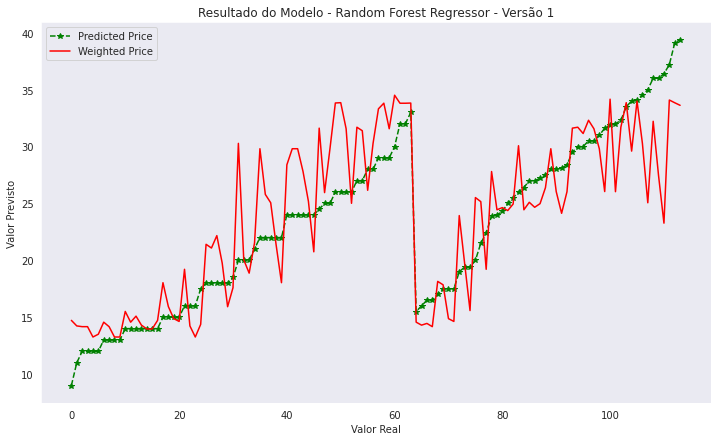

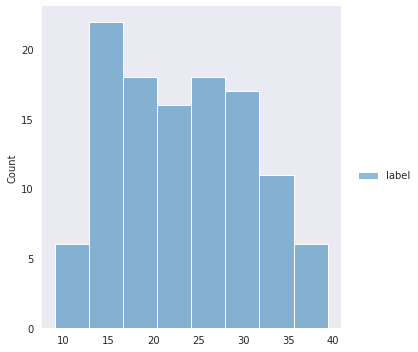

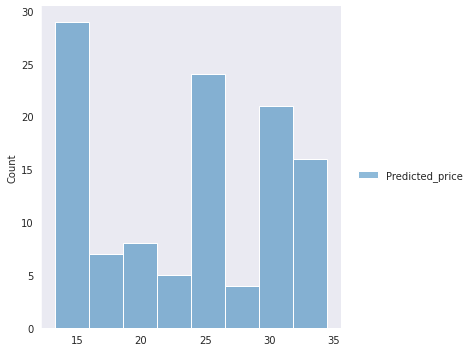


Avaliação do Modelo (Random Forest Regressor - Versão 1)

MAE - Erro Médio Absoluto: 2.857663624320638
MSE - Erro Quadrático Médio: 13.90997295729325
RMSE - Raiz Quadrada do Erro Quadrático Médio: 3.729607614386968
Coeficiente R2: 0.737833510447353
Variância Explicada: 0.7429931209698852


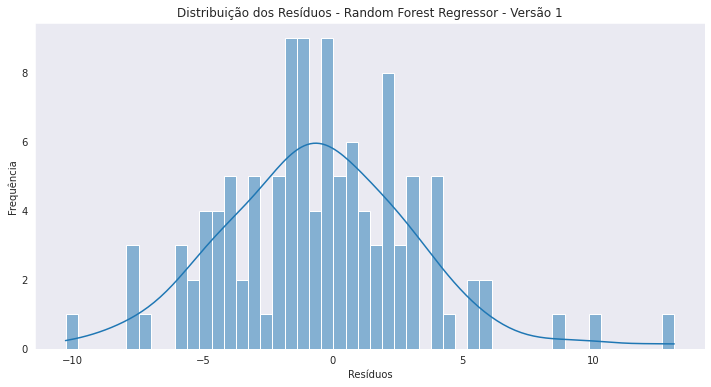

In [50]:
# Criação e Treinamento
modelo_rf_v1 = RandomForestRegressor(featuresCol='scaled_features', labelCol='label', predictionCol='Predicted_price')
modelo_v1_rf = modelo_rf_v1.fit(dados_treino)

# Previsões
previsoes_v1_rf = modelo_v1_rf.transform(dados_teste)
previsoes_v1_rf.select("Predicted_price", "label").show(10)

# Avaliações
mae_v1_rf = previsoes_v1_rf.selectExpr("avg(abs(Predicted_price - label)) as mae").collect()[0]["mae"]
print(f"Mean Absolute Error (MAE) nos dados de teste: {mae_v1_rf}")

evaluator_v1_rf = RegressionEvaluator(labelCol="label", predictionCol="Predicted_price", metricName="rmse")
rmse_v1_rf = evaluator_v1_rf.evaluate(previsoes_v1_rf)
print(f"Root Mean Squared Error (RMSE) nos dados de teste = {rmse_v1_rf}")

# Extração e plotagem das previsões
Y_v1_rf = previsoes_v1_rf.select('label').toPandas()
_Y_v1_rf = previsoes_v1_rf.select("Predicted_price").toPandas()

plt.figure(figsize=(12, 7))
plt.plot(Y_v1_rf, color='green', marker='*', linestyle='dashed', label='Predicted Price')
plt.plot(_Y_v1_rf, color='red', label='Weighted Price')
plt.title('Resultado do Modelo - Random Forest Regressor - Versão 1')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

sns.set_style("dark")
sns.displot(Y_v1_rf, color="r", label="Valores Reais")
sns.displot(_Y_v1_rf, color="b", label="Valores Previstos")
plt.show()

# Avaliação do Modelo
mae_v1_rf = mean_absolute_error(Y_v1_rf, _Y_v1_rf)
mse_v1_rf = mean_squared_error(Y_v1_rf, _Y_v1_rf)
rmse_v1_rf = np.sqrt(mse_v1_rf)
r2_v1_rf = r2_score(Y_v1_rf, _Y_v1_rf)
evs_v1_rf = explained_variance_score(Y_v1_rf, _Y_v1_rf)

print('\nAvaliação do Modelo (Random Forest Regressor - Versão 1)\n')
print(f'MAE - Erro Médio Absoluto: {mae_v1_rf}')
print(f'MSE - Erro Quadrático Médio: {mse_v1_rf}')
print(f'RMSE - Raiz Quadrada do Erro Quadrático Médio: {rmse_v1_rf}')
print(f'Coeficiente R2: {r2_v1_rf}')
print(f'Variância Explicada: {evs_v1_rf}')

# Análise de Resíduos
residuos_v1_rf = Y_v1_rf['label'] - _Y_v1_rf['Predicted_price']
df_residuos_v1_rf = pd.DataFrame({'label': Y_v1_rf['label'], 'Predicted_price': _Y_v1_rf['Predicted_price'], 'Residuo': residuos_v1_rf})

plt.figure(figsize=(12, 6))
sns.histplot(df_residuos_v1_rf['Residuo'], bins=50, kde=True)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos - Random Forest Regressor - Versão 1')
plt.show()

In [51]:
# Salvando as Métricas
modelo_v1_rf_metrics = pd.DataFrame({
    'Nome do Modelo': ['Random Forest Regressor'],
    'Versao': ['1'],
    'Tipo de Dados': ['Escalonados'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'MAE': [f"{mae_v1_rf:.2f}"],
    'MSE': [f"{mse_v1_rf:.2f}"],
    'RMSE': [rmse_v1_rf],
    'Coeficiente R2': [r2_v1_rf],
    'Variância Explicada': [evs_v1_rf]
})

df_modelos = pd.concat([df_modelos, modelo_v1_rf_metrics], ignore_index=True)
display(df_modelos)

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,MAE,MSE,RMSE,Coeficiente R2,Variância Explicada
0,Regressão Linear,1,Original,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778826,0.730868,0.731139
1,Regressão Linear,2,Escalonados,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778643,0.730895,0.731165
2,Regressão Linear,3,Original,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055
3,Regressão Linear,4,Escalonados,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055
4,Decision Tree Regressor,1,Escalonados,Sem Ajuste de Hiperparâmetros,3.12,17.37,4.167667,0.672632,0.674737
5,Random Forest Regressor,1,Escalonados,Sem Ajuste de Hiperparâmetros,2.86,13.91,3.729608,0.737834,0.742993


<br><br>

# SELECIONANDO O MELHOR MODELO

- Usaremos o modelo que .

<br>

#### Visualizando Dataframe Ordenado

In [52]:
# Ordenando o DataFrame pelo (modificar sort_values)
df_modelos_sorted = df_modelos.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

# Visualizando Daframe
display(df_modelos_sorted)

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,MAE,MSE,RMSE,Coeficiente R2,Variância Explicada
0,Random Forest Regressor,1,Escalonados,Sem Ajuste de Hiperparâmetros,2.86,13.91,3.729608,0.737834,0.742993
1,Regressão Linear,2,Escalonados,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778643,0.730895,0.731165
2,Regressão Linear,1,Original,Sem Ajuste de Hiperparâmetros,3.02,14.28,3.778826,0.730868,0.731139
3,Regressão Linear,3,Original,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055
4,Regressão Linear,4,Escalonados,Com Ajuste de Hiperparâmetros,3.13,14.98,3.870623,0.717634,0.718055
5,Decision Tree Regressor,1,Escalonados,Sem Ajuste de Hiperparâmetros,3.12,17.37,4.167667,0.672632,0.674737


<br><br>

# Salvando Pipeline com Escalas e Melhor Modelo

In [59]:
# Salvar o StandardScalerModel
scaler_model.write().overwrite().save('pipeline_e_modelo/scaler_model_rf')

# Salvar o modelo
modelo_v1_rf.write().overwrite().save('pipeline_e_modelo/best_model_rf')

print('Scaler model e modelo salvos com sucesso.')

Scaler model e modelo salvos com sucesso.


<br><br>

# Carregando Modelo e Pipeline Salvos

In [62]:
from pyspark.ml.feature import StandardScalerModel
from pyspark.ml.regression import RandomForestRegressionModel
# Carregar o StandardScalerModel
scaler_model = StandardScalerModel.load('pipeline_e_modelo/scaler_model_rf')

# Carregar o melhor modelo
best_model_rf = RandomForestRegressionModel.load('pipeline_e_modelo/best_model_rf')

print('Scaler model e modelo carregados com sucesso.')

Scaler model e modelo carregados com sucesso.


RandomForestRegressionModel: uid=RandomForestRegressor_5806f7737988, numTrees=20, numFeatures=3

<br><br>

# Previsões com Novos Dados

In [69]:
# Novos dados
novos_dados = [[4376.0, 307.0, 8.0], [4615.0, 360.0, 8.0], [3664.0, 350.0, 8.0], 
               [4633.0, 429.0, 8.0], [4997.0, 400.0, 8.0]]

# Prepara o dataframe do Pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ['peso', 'capacidade', 'numero_cilindros'])

# Converte o dataframe do Pandas para dataframe do Spark
df_novos_dados_spark = spSession.createDataFrame(df_novos_dados)

# Transformar os dados em features densas
def transformaVar(row):
    return (Vectors.dense([row['peso'], row['capacidade'], row['numero_cilindros']]),)

# Aplicar a transformação para converter as features para um vetor denso
rdd_novos_dados = df_novos_dados_spark.rdd.map(transformaVar)
df_novos_dados_transformed = spSession.createDataFrame(rdd_novos_dados, ["features"])

# Aplicar o scaler_model ao novo DataFrame transformado
novos_dados_escalados = scaler_model.transform(df_novos_dados_transformed)

# Fazer previsões usando o modelo carregado
previsoes = best_model_rf.transform(novos_dados_escalados)

# Mostrar o schema para descobrir o nome da coluna de previsão
previsoes.printSchema()

# Mostrar as previsões
previsoes.select("features", "Predicted_price").show()

root
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- Predicted_price: double (nullable = false)

+------------------+------------------+
|          features|   Predicted_price|
+------------------+------------------+
|[4376.0,307.0,8.0]|14.128377320616625|
|[4615.0,360.0,8.0]|13.507012058739198|
|[3664.0,350.0,8.0]|15.937245430430224|
|[4633.0,429.0,8.0]| 13.26212075439137|
|[4997.0,400.0,8.0]| 13.26212075439137|
+------------------+------------------+



<br>

# FIM!